# Import Libraries

In [171]:
%pylab inline
import numpy as np
import pandas as pd
import shutil
import os

from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation, Bidirectional, Merge, Dropout, Reshape
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.metrics import mean_squared_error
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from keras.callbacks import Callback, EarlyStopping, TensorBoard


from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse

from IPython.display import display
from IPython.display import SVG, Image
from keras.utils.vis_utils import model_to_dot

Populating the interactive namespace from numpy and matplotlib


# Data

[S&P 500 (^GSPC)](https://finance.yahoo.com/quote/%5EGSPC/history?period1=-631184400&period2=1499612400&interval=1d&filter=history&frequency=1d) 에서 1950/01/01 부터 07/07/2017년까지의 데이터를 받았습니다.<br>
테스트용으로서 Dataset전체에 대해서 standardization을 했습니다.

data_x : (16947, 190)
data_y : (16947, 1)
train_x: (13557, 190)
train_y: (13557, 1)
test_x : (3390, 190)
test_y : (3390, 1)


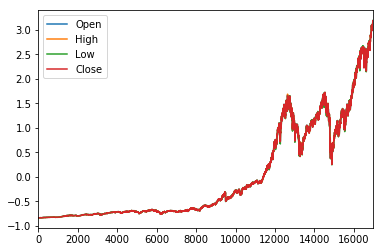

In [8]:
BATCH_SIZE = 38
LAG_SIZE = 1
TRAINING_SIZE = 400

raw_data = pd.read_csv('./GSPC.csv')
raw_data['Date'] = pd.to_datetime(raw_data['Date'])
# raw_data = raw_data[::-1]

def preprocess(data):
    X_COLUMNS = ['Open', 'High', 'Low', 'Close', 'Volume']
    Y_COLUMNS = ['y']
    COLUMNS = X_COLUMNS + Y_COLUMNS
    
    # Standardization
    scaler = StandardScaler()
    data[X_COLUMNS] = scaler.fit_transform(data[X_COLUMNS])
    
    # Create Y
    # 반드시 Standardization이후에 와야 함
    data['y'] = data.Close.shift(-1)
    data = data.dropna()
    
    # BATCH
    data = data[:data.shape[0]-data.shape[0]%BATCH_SIZE]
    data = data[COLUMNS].as_matrix()

    # Split X and Y
    N = data.shape[0]-BATCH_SIZE -1
    data_x = np.zeros((N, BATCH_SIZE, 5))
    data_y = np.zeros((N, 1))
    
    for i in range(N):
        end = i + BATCH_SIZE + 1
        series = data[i:end]
        
        data_x[i, :] = series[:BATCH_SIZE, :-1].reshape(BATCH_SIZE, 5)
        data_y[i] = series[BATCH_SIZE:, -1]
    
    data_x = data_x.reshape((-1, BATCH_SIZE*5))
    return scaler, data_x, data_y

def split_train_test(data_x, data_y, test_size=0.2):
    train_size = int(data_y.shape[0] * (1-test_size))
    
    train_x, test_x = data_x[:train_size], data_x[train_size:]
    train_y, test_y = data_y[:train_size], data_y[train_size:]
        
    return train_x, train_y, test_x, test_y
    
scaler, data_x, data_y = preprocess(raw_data)
train_x, train_y, test_x, test_y = split_train_test(data_x, data_y)

print('data_x :', data_x.shape)
print('data_y :', data_y.shape)
print('train_x:', train_x.shape)
print('train_y:', train_y.shape)
print('test_x :', test_x.shape)
print('test_y :', test_y.shape)

raw_data[['Open', 'High', 'Low', 'Close']].plot()

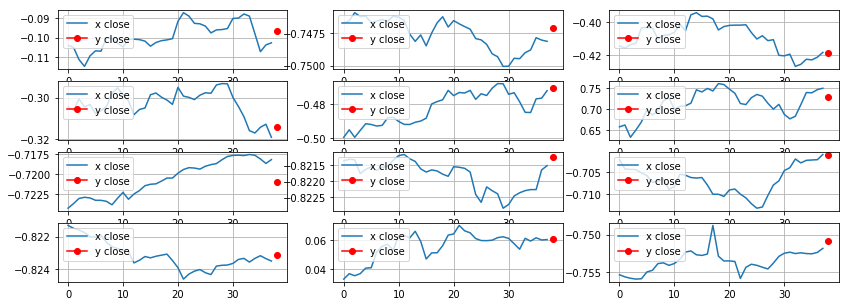

In [9]:
def visualize_data(x, y):
    f, plots = subplots(4, 3)
    f.set_figheight(5)
    f.set_figwidth(14)
    plots = plots.reshape(-1)
    
    for p in plots:
        idx = np.random.randint(x.shape[0])
        t = np.arange(BATCH_SIZE+1)
        p.plot(t[:-1], x[idx,  np.arange(3, BATCH_SIZE*5, 5)], label="x close")
        p.plot(t[-1], y[idx], label='y close', marker='o', color='red')
        p.legend(loc='upper left')
        p.grid()
        
visualize_data(train_x, train_y)

# Model

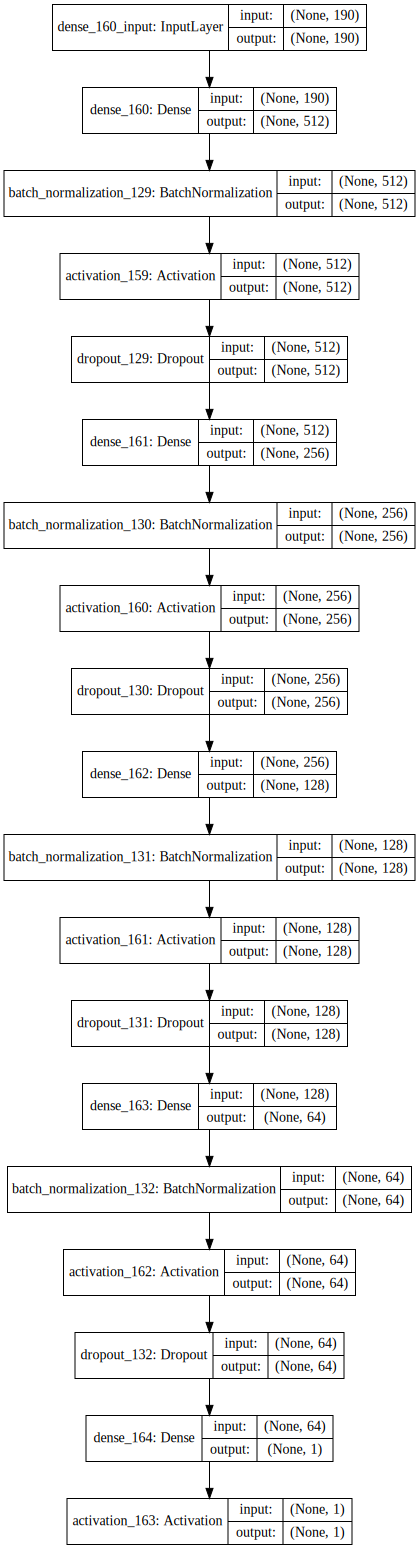

In [176]:
INPUT_N = train_x.shape[-1]
def create_model():
    model = Sequential()
    model.add(Dense(512, kernel_regularizer=l2(0.0005), batch_input_shape=(None, BATCH_SIZE*5)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.4))
    
#     model.add(Dense(384, kernel_regularizer=l2(0.0001)))
#     model.add(BatchNormalization())
#     model.add(Activation('relu'))
#     model.add(Dropout(0.6))
    
    model.add(Dense(256, kernel_regularizer=l2(0.0003)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.3))
    
    model.add(Dense(128, kernel_regularizer=l2(0.0002)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    
    model.add(Dense(64, kernel_regularizer=l2(0.0002)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.1))
            
    model.add(Dense(1))
    model.add(Activation('linear'))
    model.compile(loss='mean_squared_error', 
                  optimizer=Adam(lr=0.00001), 
                  metrics=[mean_squared_error])
    
    if os.path.exists('./logs'):
        shutil.rmtree('./logs')
    return model
    
model = create_model()
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))


# Training

In [182]:
# Callbacks
class CustomEarlyStopping(EarlyStopping):
    def __init__(self, *args, min_epoch=0, **kwargs):
        super(CustomEarlyStopping, self).__init__(*args, **kwargs)
        self.min_epoch = min_epoch
    
    def on_epoch_end(self, epoch, logs=None):
        if epoch <= self.min_epoch:
            return
        super(CustomEarlyStopping, self).on_epoch_end(epoch, logs)    

early_stopping = CustomEarlyStopping('val_mean_squared_error', 
                                     min_epoch=4, 
                                     min_delta=0.05,
                                     patience=0)

# tesorboard = TensorBoard(batch_size=BATCH_SIZE)

# Training
def train(n_try=10):
    best = 100
    best_model = None
    for i in range(n_try):
        model = create_model()
        history = model.fit(train_x, train_y, 
                            verbose=2, 
                            epochs=20, 
                            validation_data=(test_x, test_y), 
                            callbacks=[early_stopping])
    
        val_loss, val_mse = model.evaluate(test_x, test_y, batch_size=BATCH_SIZE, verbose=2)
        if best > val_mse:
            best = val_mse
            best_model = model
            print('Best Value:', best) 
    return best_model

model = train(n_try=100)

Train on 13557 samples, validate on 3390 samples
Epoch 1/20
6s - loss: 1.3858 - mean_squared_error: 1.0949 - val_loss: 0.7278 - val_mean_squared_error: 0.4372
Epoch 2/20
5s - loss: 0.9161 - mean_squared_error: 0.6257 - val_loss: 4.2788 - val_mean_squared_error: 3.9886
Epoch 3/20
5s - loss: 0.8402 - mean_squared_error: 0.5504 - val_loss: 3.1385 - val_mean_squared_error: 2.8489
Epoch 4/20
5s - loss: 0.7890 - mean_squared_error: 0.4997 - val_loss: 1.3097 - val_mean_squared_error: 1.0207
Epoch 5/20
5s - loss: 0.7497 - mean_squared_error: 0.4611 - val_loss: 0.8870 - val_mean_squared_error: 0.5987
Epoch 6/20
5s - loss: 0.7137 - mean_squared_error: 0.4257 - val_loss: 0.8773 - val_mean_squared_error: 0.5896
Epoch 7/20
5s - loss: 0.6921 - mean_squared_error: 0.4048 - val_loss: 0.7428 - val_mean_squared_error: 0.4558
Epoch 8/20
5s - loss: 0.6419 - mean_squared_error: 0.3553 - val_loss: 0.9510 - val_mean_squared_error: 0.6648
Epoch 9/20
5s - loss: 0.6149 - mean_squared_error: 0.3290 - val_loss: 1

KeyboardInterrupt: 

Minimum validation MSE: 0.796997119561


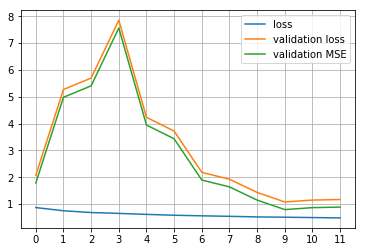

In [178]:
plot(history.epoch, history.history['loss'], label='loss')
plot(history.epoch, history.history['val_loss'], label='validation loss')
plot(history.epoch, history.history['val_mean_squared_error'], label='validation MSE')
print('Minimum validation MSE:', np.min(history.history['val_mean_squared_error']))
xticks(history.epoch)
legend()
grid()

TRAIN r^2 score: 0.894713054137
TRAIN MSE score: 0.0256735695794
TEST  r^2 score: -0.440082754923
TRAIN MSE score: 0.890322587324


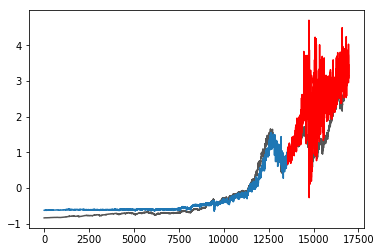

In [179]:
def validate(x_train, y_train, x_test, y_test):
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)
    
    train_n = y_train_pred.shape[0]
    test_n = y_test_pred.shape[0]
    x = np.arange(train_n + test_n)
    
    plot(x[:train_n], y_train, color='#555555')
    plot(x[:train_n], y_train_pred)
    
    plot(x[train_n:], y_test, color='#555555')
    plot(x[train_n:], y_test_pred, color='red')
    
    print('TRAIN r^2 score:', r2_score(y_train_pred, y_train))
    print('TRAIN MSE score:', mse(y_train_pred, y_train))
    
    print('TEST  r^2 score:', r2_score(y_test_pred, y_test))
    print('TRAIN MSE score:', mse(y_test_pred, y_test))
    
validate(train_x, train_y, test_x, test_y)